## Initialization

In [72]:
import sys
import os

# Add the parent directory to sys.path
THIS_DIR = os.path.abspath(os.path.join('.'))
PARENT_DIR = os.path.abspath(os.path.join('..'))
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.insert(0, THIS_DIR)

import torch, argparse
import autograd.numpy as np
from nn_models import MLP
from hnn import HNN
from data import get_dataset, dynamics_fn, hamiltonian_fn
from utils import L2_loss, rk4

import scipy.integrate

solve_ivp = scipy.integrate.solve_ivp


## Help Functions


In [73]:
# print squared loss at specific steps for comparison with HNN
print_every = 200
def print_results(results, print_every=200):
    for step in range(0, len(results["train_loss"]), print_every):
        print(
            "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                step,
                results["train_loss"][step],
                results["test_loss"][step],
            )
        )
    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
        .format(results["train_loss"][-1], results["train_std"][-1],
                results["test_loss"][-1], results["test_std"][-1]))

def print_best(results):
    curr_min = 0

    for step in range(0, len(results["train_loss"])):
        if results["test_loss"][step] < results["test_loss"][curr_min]:
            curr_min = step
    print(
        "best test loss at step {}, train_loss {:.4e}, test_loss {:.4e}".format(
            curr_min,
            results["train_loss"][curr_min],
            results["test_loss"][curr_min],
        )
    )


In [74]:
def get_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument(
        "--input_dim", default=2, type=int, help="dimensionality of input tensor"
    )
    parser.add_argument(
        "--hidden_dim", default=200, type=int, help="hidden dimension of mlp"
    )
    parser.add_argument("--learn_rate", default=1e-3, type=float, help="learning rate")
    parser.add_argument(
        "--nonlinearity", default="tanh", type=str, help="neural net nonlinearity"
    )
    parser.add_argument(
        "--total_steps", default=2000, type=int, help="number of gradient steps"
    )
    parser.add_argument(
        "--print_every",
        default=200,
        type=int,
        help="number of gradient steps between prints",
    )
    parser.add_argument(
        "--name", default="spring", type=str, help="only one option right now"
    )
    parser.add_argument(
        "--baseline",
        dest="baseline",
        action="store_true",
        help="run baseline or experiment?",
    )
    parser.add_argument(
        "--use_rk4",
        dest="use_rk4",
        action="store_true",
        help="integrate derivative with RK4",
    )
    parser.add_argument(
        "--verbose", dest="verbose", action="store_true", help="verbose?"
    )
    parser.add_argument(
        "--kan", dest="kan", action="store_true", help="use kan instead of mlp?"
    )
    parser.add_argument(
        "--field_type",
        default="solenoidal",
        type=str,
        help="type of vector field to learn",
    )
    parser.add_argument("--seed", default=0, type=int, help="random seed")
    parser.add_argument(
        "--save_dir", default=THIS_DIR, type=str, help="where to save the trained model"
    )
    parser.set_defaults(feature=True)
    return parser.parse_args()


In [75]:
def get_trajectory_drv(
    t_span=[0, 3], timescale=10, radius=None, y0=None, noise_std=0.1, **kwargs
):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale * (t_span[1] - t_span[0])))

    # get initial state
    if y0 is None:
        y0 = np.random.rand(2) * 2 - 1
    if radius is None:
        radius = np.random.rand() * 0.9 + 0.1  # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius  ## set the appropriate radius

    spring_ivp = solve_ivp(
        fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs
    )
    q, p = spring_ivp["y"][0], spring_ivp["y"][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp["y"].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt, 2)

    # add noise
    dqdt += np.random.randn(*dqdt.shape) * noise_std
    dpdt += np.random.randn(*dpdt.shape) * noise_std
    return q, p, dqdt, dpdt, t_eval


def get_dataset_drv(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {"meta": locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory_drv(**kwargs)
        xs.append(np.stack([x, y]).T)
        dxs.append(np.stack([dx, dy]).T)

    data["x"] = np.concatenate(xs)
    data["dx"] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data["x"]) * test_split)
    split_data = {}
    for k in ["x", "dx"]:
        split_data[k], split_data["test_" + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [76]:
def train(args, noise_std=0.05, drv=False):
    # set random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)

    # init model and optimizer
    if args.verbose:
        print("Training baseline model:" if args.baseline else "Training HNN model:")

    output_dim = args.input_dim if args.baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(
        args.input_dim,
        differentiable_model=nn_model,
        field_type=args.field_type,
        baseline=args.baseline,
    )
    optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=1e-4)

    # arrange data
    data = get_dataset(seed=args.seed, noise_std=noise_std) if drv else get_dataset_drv(seed=args.seed,noise_std=noise_std)
    x = torch.tensor(data["x"], requires_grad=True, dtype=torch.float32)
    test_x = torch.tensor(data["test_x"], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data["dx"])
    test_dxdt = torch.Tensor(data["test_dx"])

    # vanilla train loop
    stats = {"train_loss": [], "test_loss": []}
    for step in range(args.total_steps + 1):

        # train step
        dxdt_hat = (
            model.rk4_time_derivative(x) if args.use_rk4 else model.time_derivative(x)
        )
        loss = L2_loss(dxdt, dxdt_hat)
        loss.backward()
        optim.step()
        optim.zero_grad()

        # run test data
        test_dxdt_hat = (
            model.rk4_time_derivative(test_x)
            if args.use_rk4
            else model.time_derivative(test_x)
        )
        test_loss = L2_loss(test_dxdt, test_dxdt_hat)

        # logging
        stats["train_loss"].append(loss.item())
        stats["test_loss"].append(test_loss.item())
        if args.verbose and step % args.print_every == 0:
            print(
                "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                    step, loss.item(), test_loss.item()
                )
            )

    train_dxdt_hat = model.time_derivative(x)
    train_dist = (dxdt - train_dxdt_hat) ** 2
    test_dxdt_hat = model.time_derivative(test_x)
    test_dist = (test_dxdt - test_dxdt_hat) ** 2
    print(
        "Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}".format(
            train_dist.mean().item(),
            train_dist.std().item() / np.sqrt(train_dist.shape[0]),
            test_dist.mean().item(),
            test_dist.std().item() / np.sqrt(test_dist.shape[0]),
        )
    )

    return model, stats


## Train for multiple std

In [77]:
stds = [0.05, 0.1, 0.15]
args = get_args()
args.verbose = True

for std in stds:
    model, stats = train(args, noise_std=std)

    # save
    os.makedirs(args.save_dir) if not os.path.exists(args.save_dir) else None
    label = "-baseline" if args.baseline else "-hnn"
    label += "-" + str(std)
    path = "{}/{}{}.tar".format(args.save_dir, args.name, label)
    torch.save(model.state_dict(), path)

drv = True
for std in stds:
    model, stats = train(args, noise_std=std, drv=drv)

    # save
    os.makedirs(args.save_dir) if not os.path.exists(args.save_dir) else None
    label = "-baseline" if args.baseline else "-hnn"
    label += "-" + str(std)
    label += "-drv"
    path = "{}/{}{}.tar".format(args.save_dir, args.name, label)
    torch.save(model.state_dict(), path)

Training HNN model:
step 0, train_loss 8.0803e-01, test_loss 7.8091e-01
step 200, train_loss 2.7451e-03, test_loss 2.7072e-03
step 400, train_loss 2.5276e-03, test_loss 2.5383e-03
step 600, train_loss 2.5132e-03, test_loss 3.0202e-03
step 800, train_loss 2.4529e-03, test_loss 2.4786e-03
step 1000, train_loss 2.4434e-03, test_loss 2.4725e-03
step 1200, train_loss 2.4437e-03, test_loss 2.4819e-03
step 1400, train_loss 2.4298e-03, test_loss 2.4651e-03
step 1600, train_loss 2.4300e-03, test_loss 2.4618e-03
step 1800, train_loss 2.4325e-03, test_loss 2.4704e-03
step 2000, train_loss 2.4162e-03, test_loss 2.4570e-03
Final train loss 2.4185e-03 +/- 1.2260e-04
Final test loss 2.4570e-03 +/- 1.2870e-04
Training HNN model:
step 0, train_loss 8.1268e-01, test_loss 7.8688e-01
step 200, train_loss 9.9007e-03, test_loss 9.9251e-03
step 400, train_loss 9.7855e-03, test_loss 9.9277e-03
step 600, train_loss 9.6605e-03, test_loss 9.7940e-03
step 800, train_loss 9.6169e-03, test_loss 9.7295e-03
step 1000

## Plot

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk")  # Use Seaborn's white grid style


In [105]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''
EXPERIMENT_DIR = './experiment-spring'
sys.path.append(EXPERIMENT_DIR)

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [109]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_models(model, x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # rescale time to compensate for noise effects, as described in appendix
    t_span[1] *= 1 + .9*noise_std
    t_eval *= 1 + .9*noise_std

    # integrate along HNN vector field
    hnn_path = integrate_model(model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor(true_x, requires_grad=True, dtype=torch.float32)

    return true_x, hnn_x

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

def get_model(args, std, drv):
    output_dim = 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=False)
    
    model_name = 'hnn'
    path = "spring-{}-{}.tar".format(model_name, std) if not drv else "spring-{}-{}-drv.tar".format(model_name, std)
    model.load_state_dict(torch.load(path))
    return model

In [111]:
args = ObjectView(get_args())
models = {}

stds = [0.05, 0.1, 0.15]
for std in stds:
    for drv in [True, False]:
        key = (std, drv)
        models[key] = get_model(args, std, drv)

/var/folders/yf/ztggt9hs5mvc5xgtr219fdp00000gp/T/ipykernel_65046/4021912007.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


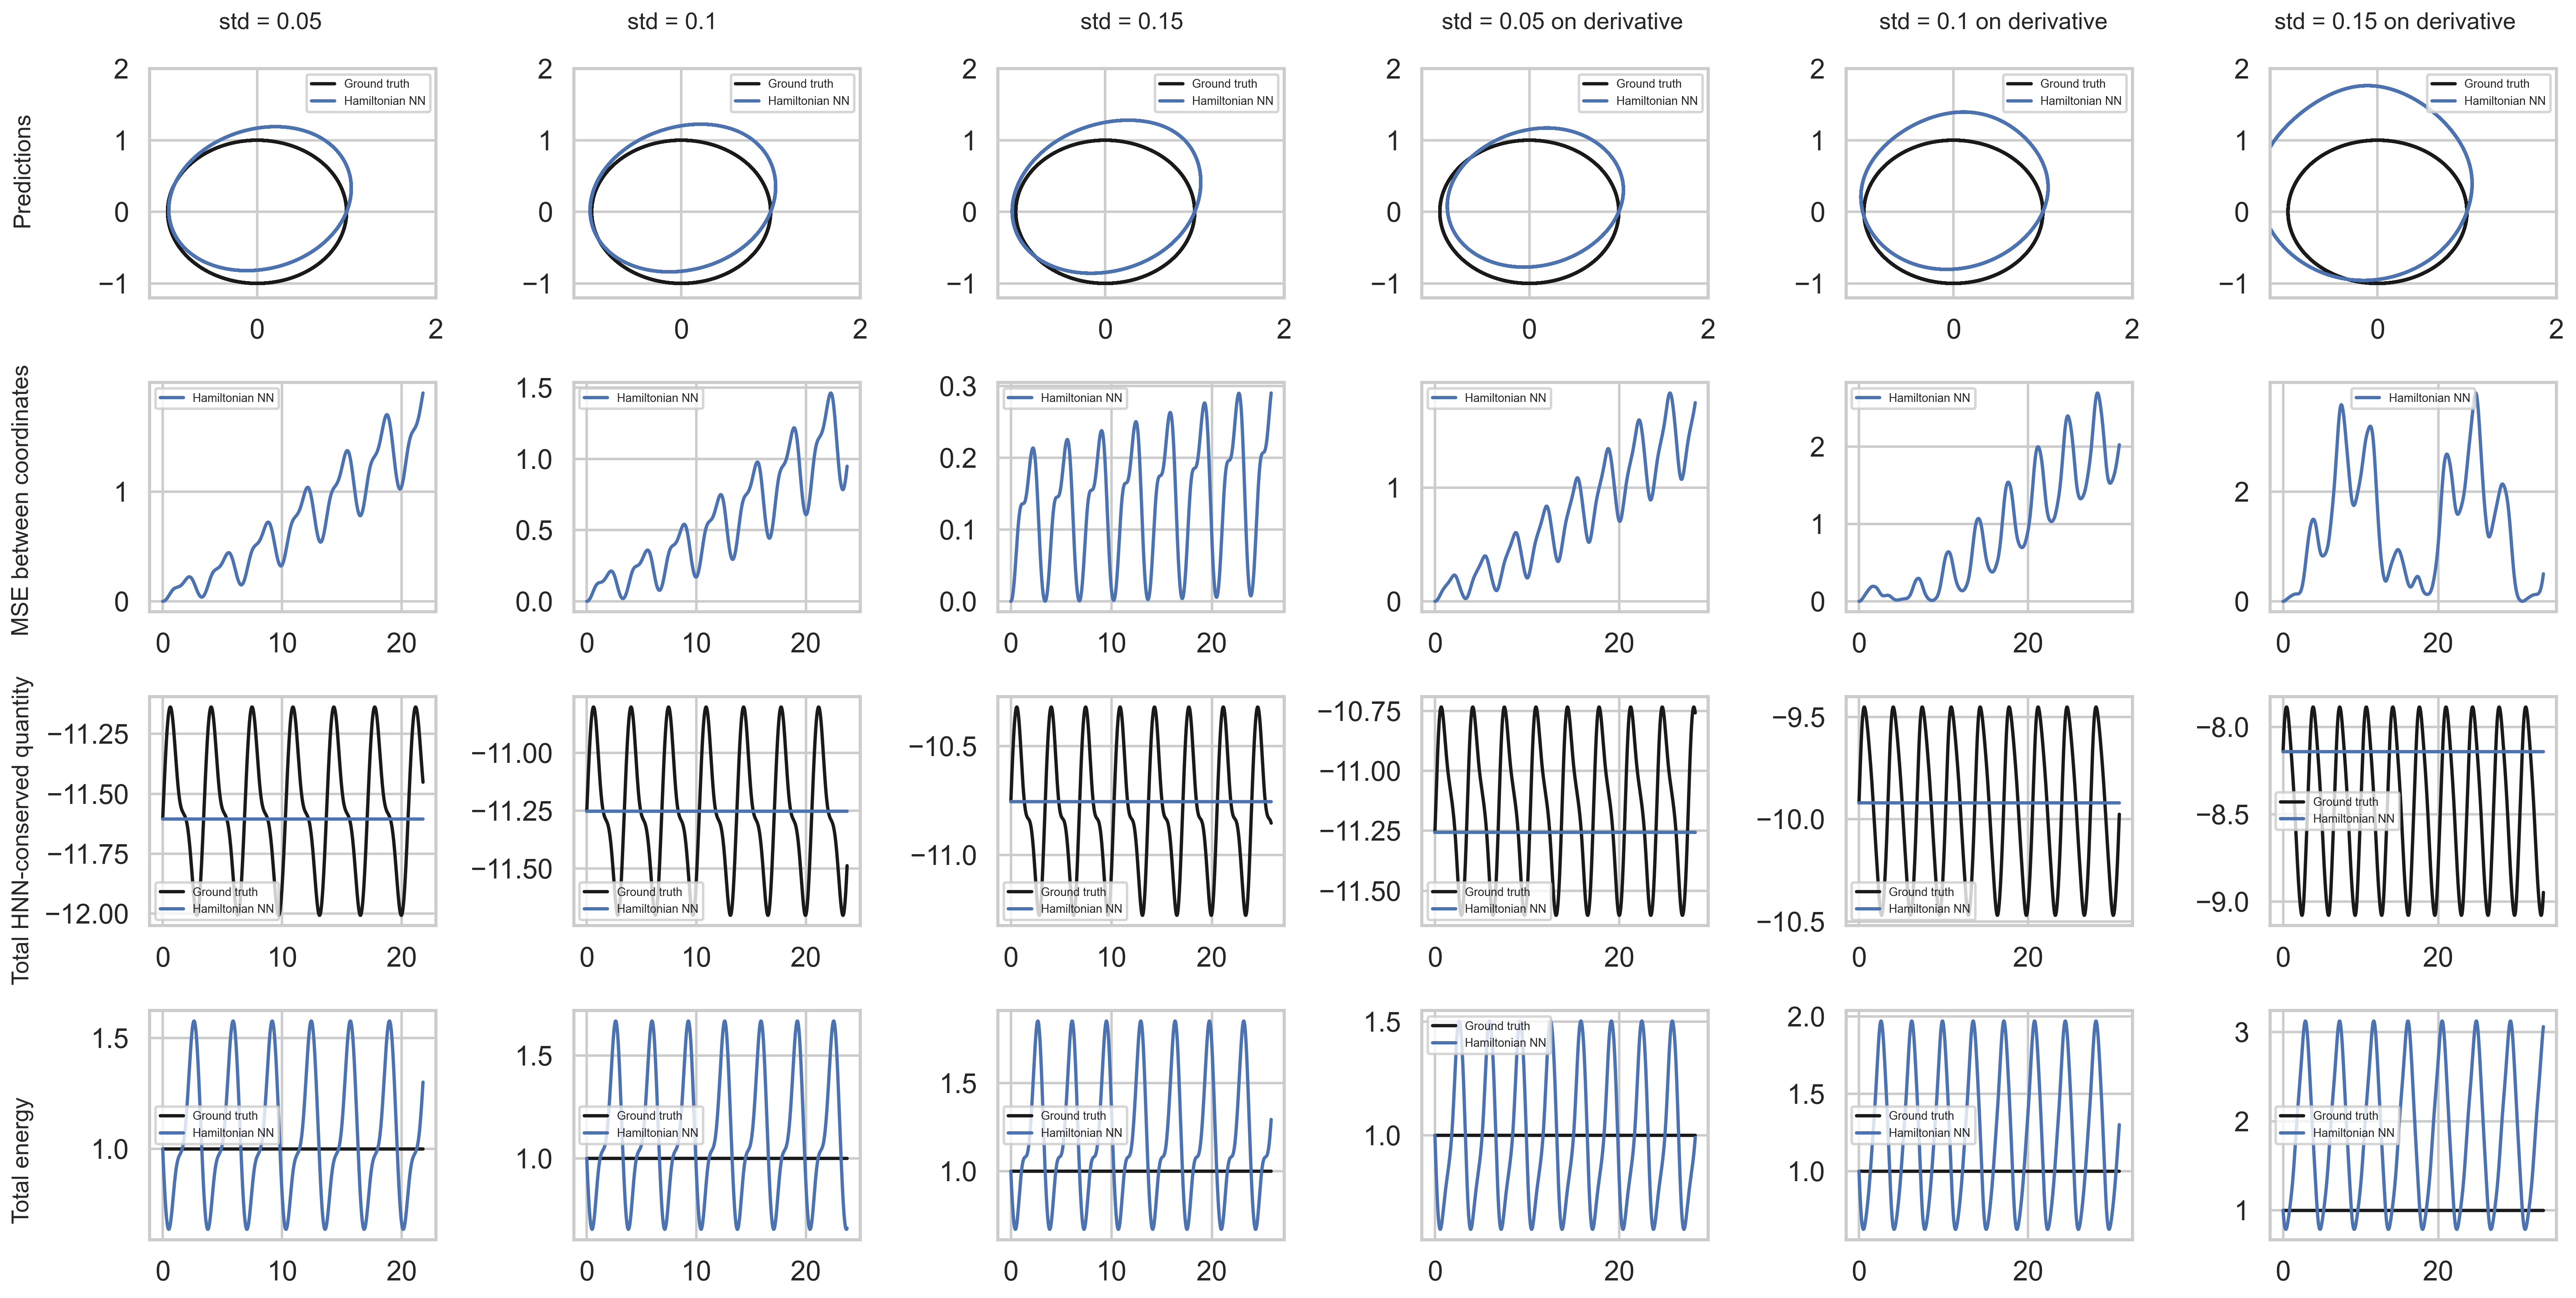

In [157]:

x0 = np.asarray([1, 0])
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
tpad = 7
fig, axes = plt.subplots(4, 6, figsize=[24, 12], dpi=DPI)

# Loop over rows and columns
for i, drv in enumerate([False, True]):
    for j, std in enumerate(stds):
        key = (std, drv)
        model = models[key]

        # Integration
        true_x, hnn_x = integrate_models(model, x0=x0, t_span=t_span, t_eval=t_eval)

        # Plot: Predictions
        ax = axes[0, j + i * 3]  # First row
        ax.plot(true_x[:, 0], true_x[:, 1], 'k-', label='Ground truth', linewidth=2)
        ax.plot(hnn_x[:, 0], hnn_x[:, 1], "b-", label="Hamiltonian NN", linewidth=2)
        ax.set_xlim(-1.2, 2)
        ax.set_ylim(-1.2, 2)
        ax.legend(fontsize=7)

        # Plot: MSE
        ax = axes[1, j + i * 3]
        ax.plot(t_eval, ((true_x - hnn_x) ** 2).mean(-1), "b-", label="Hamiltonian NN", linewidth=2)
        ax.legend(fontsize=7)

        # Plot: Total HNN-conserved quantity
        ax = axes[2, j + i * 3]
        true_hq = model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
        hnn_hq = model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
        ax.plot(t_eval, true_hq, "k-", label="Ground truth", linewidth=2)
        ax.plot(t_eval, hnn_hq, "b-", label="Hamiltonian NN", linewidth=2)
        ax.legend(fontsize=7)

        # Plot: Total energy
        ax = axes[3, j + i * 3]
        true_e = np.stack([hamiltonian_fn(c) for c in true_x])
        hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
        ax.plot(t_eval, true_e, "k-", label="Ground truth", linewidth=2)
        ax.plot(t_eval, hnn_e, "b-", label="Hamiltonian NN", linewidth=2)
        ax.legend(fontsize=7)

std_labels = ["std = 0.05", "std = 0.1", "std = 0.15", 
              "std = 0.05 on derivative", "std = 0.1 on derivative", "std = 0.15 on derivative"]
row_labels = ["Predictions", "MSE between coordinates", "Total HNN-conserved quantity", "Total energy"]

# Common X and Y labels
# fig.supxlabel("Time Step", fontsize=14, y=0.08)
# fig.supylabel("Quantity Value", fontsize=14, x=0.08)

# Column Titles (std values)
fig.text(0.14, 0.96, std_labels[0], ha="center", va="top", fontsize=14)
fig.text(0.28, 0.96, std_labels[1], ha="center", va="top", fontsize=14)
fig.text(0.44, 0.96, std_labels[2], ha="center", va="top", fontsize=14)
fig.text(0.59, 0.96, std_labels[3], ha="center", va="top", fontsize=14)
fig.text(0.74, 0.96, std_labels[4], ha="center", va="top", fontsize=14)
fig.text(0.88, 0.96, std_labels[5], ha="center", va="top", fontsize=14)

# Row Titles (left side)
for i in range(4):
    fig.text(0.05, 0.85 - i * 0.23, row_labels[i], ha="left", va="center", fontsize=14, rotation=90)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust layout to fit labels
plt.show()


fig.savefig('{}/spring-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))